# 1. <a id='toc1_'></a>[Machine Learning based methods for prediction](#toc0_)

**Table of contents**<a id='toc0_'></a>    
1. [Machine Learning based methods for prediction](#toc1_)    
1.1. [Extreme Gradient Boosting (XGBoost)](#toc1_1_)    
1.2. [Support Vector Regression (SVR)](#toc1_2_)    
1.3. [Random Forest (RF)](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In the following notebook, we will explore the use of machine learning methods for navigation prediction. The following methods will be explored:
1. [**Extreme Gradient Boosting**](#toc1_1_) (XGBoost): </br>This method involves training a classifier to predict the arrival port based on historical voyages. It has shown an accuracy of 72% in some studies, making it useful for analyzing the predictability of different vessel segments and sub-segments.
2. [**Support Vector Regression**](#toc1_2_) (SVR): </br>SVR is used to predict continuous values, such as the future position of a ship. It is one of the classical machine learning methods evaluated for ship trajectory prediction.
3. [**Random Forest**](#toc1_3_) (RF): </br>RF is another machine learning method used for predicting ship trajectories. It is known for its robustness and ability to handle large datasets.

## Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2

### Importing Libraries

In [2]:
## Importing Libraries >>
import numpy as np
import pandas as pd

import os
import sys
from typing import List, Tuple, Dict, Any, Optional, Callable, Union
from pathlib import Path

from pprint import pprint

# Add root directory to path for imports >
root_dir = Path.cwd().resolve().parent
if root_dir.exists():
    sys.path.append(str(root_dir))
else:
    raise FileNotFoundError('Root directory not found')

import dotsi
import itertools
import pickle

import time
from datetime import datetime, timedelta

import xgboost as xgb
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots  # https://github.com/garrettj403/SciencePlots?tab=readme-ov-file
small_plt_type = ['science', 'grid', 'notebook']
big_plt_type = ['science', 'grid', 'notebook', 'ieee']

def use_scienceplots_style(styles: List[str] = small_plt_type, background: str = 'white'):
    plt.style.use(styles)
    if background == 'white':
        plt.rcParams['figure.facecolor'] = 'white'
        plt.rcParams['axes.facecolor'] = 'white'
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['xtick.color'] = 'black'
        plt.rcParams['ytick.color'] = 'black'
        plt.rcParams['text.color'] = 'black'
        plt.rcParams['axes.labelcolor'] = 'black'
        plt.rcParams['axes.titlecolor'] = 'black'
        
# Use the function to set the style
use_scienceplots_style()

# Multiprocessing >
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import joblib

# %matplotlib inline
%matplotlib widget

### Macros

In [3]:
### Macros
TIME_IT = True
DEBUG = True
TUTORIAL = True

In [4]:
# WORKING SERVER
AVAILABLE_SERVERS = ['ZS', 'PLOEN', 'KIEL', 'WYK']
CURRENT_SERVER = AVAILABLE_SERVERS[1]

# Use up to 70% of the available cpu cores
n_jobs = joblib.cpu_count()
print(f"Number of CPUs available in {CURRENT_SERVER}: {n_jobs}")
if CURRENT_SERVER == 'ZS':
    n_jobs = int(0.9 * n_jobs)
else:
    n_jobs = int(0.7 * n_jobs)
print(f"\t > Number of CPUs to use: {n_jobs}")

# seed
split_seed = 42

# Time resolution between two consecutive points in the data
targeted_resolution_sec = 10  # sec

Number of CPUs available in PLOEN: 64
	 > Number of CPUs to use: 44


### Paths

In [5]:
## PATHS >>>
# data dir
assets_dir = root_dir / 'assets'
assets_dir = assets_dir.resolve()
if not assets_dir.exists():
    raise FileNotFoundError('Data directory not found')


# Targeted data dir
if TUTORIAL:
    data_dir = assets_dir / 'data' / 'hourly_energy_consumption'
else:
    data_dir = None
if not data_dir.exists():
    raise FileNotFoundError('Data directory not found')

### Dataset

In [6]:
DATASETS = ['dummy_navigation', 
            'real_navigation', 
            'tutorial'  # Source: https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt
            ]
CURRENT_DATASET = DATASETS[2]

+ Dummy Navigation Data ``dummy_navigation``

In [7]:
if CURRENT_DATASET == 'dummy_navigation':
    # Number of time steps
    num_steps = 100

    # Parameters for sine wave path
    amplitude = 0.1  # Amplitude of the sine wave
    frequency = 0.1  # Frequency of the sine wave (in cycles per time step)
    period = 2 * np.pi / frequency  # Period of the sine wave

    # Generate synthetic data for SOG and COG
    sog = np.random.normal(loc=10, scale=2, size=num_steps)
    cog = np.random.uniform(low=0, high=360, size=num_steps)

    # Generate synthetic latitude and longitude based on sine wave path
    initial_lat, initial_lon = 54, 10
    time = np.arange(num_steps)
    latitude = [initial_lat + amplitude * np.sin(2 * np.pi * frequency * t) for t in time]
    longitude = [initial_lon + amplitude * np.cos(2 * np.pi * frequency * t) for t in time]

    ## Combine into a single dataset >>
    data_sin = np.column_stack((latitude, longitude, sog, cog))

    ## Plot original data >>
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(latitude, label='Latitude')
    plt.title('Sine Wave Path')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(longitude, label='Longitude')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(sog, label='SOG')
    plt.plot(cog, label='COG')
    plt.legend()

    plt.tight_layout()
    plt.show()

+ Real Navigation Data ``real_navigation``

In [8]:
if CURRENT_DATASET ==  'real_navigation':
    raise notImplementedError('Real navigation data not available')

+ Tutorial: Hourly energy consumption data ``tutorial``

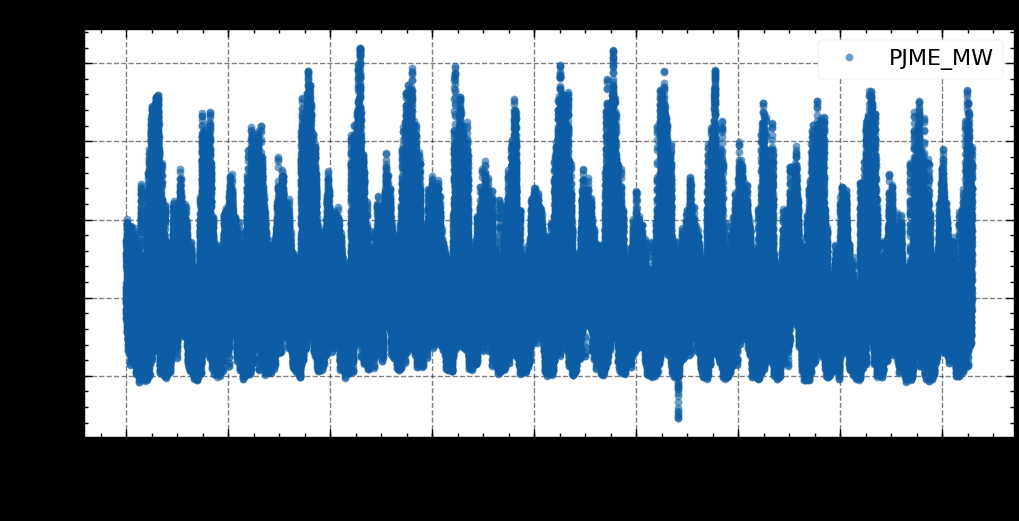

In [9]:
if CURRENT_DATASET == 'tutorial':
    df = pd.read_csv(data_dir / 'PJME_hourly.csv')
    df = df.set_index('Datetime')
    df.index = pd.to_datetime(df.index)
    
    df.plot(style='o',
            alpha=0.6,
            figsize=(12, 6),
            title='PJME hourly energy consumption')

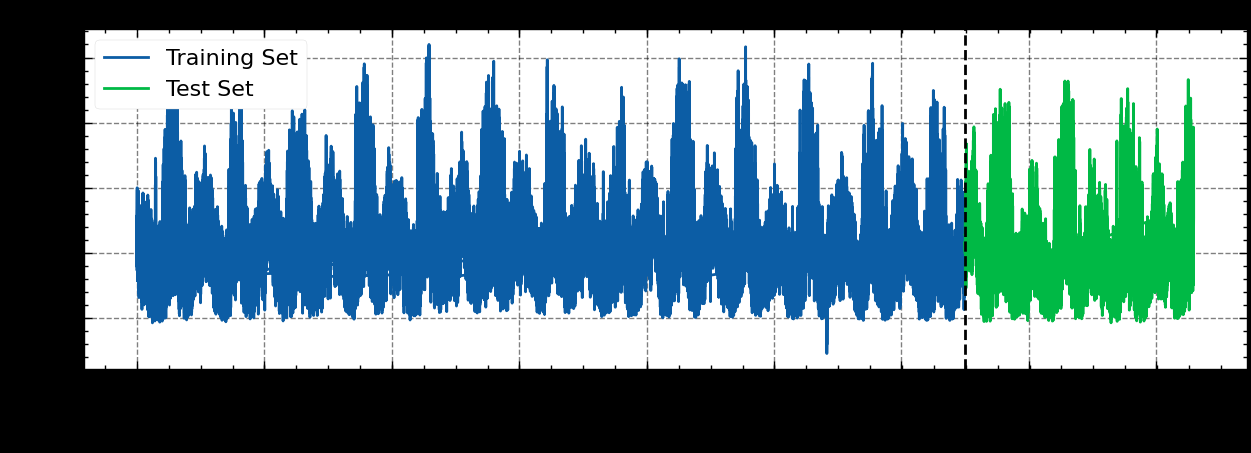

In [10]:
if CURRENT_DATASET == 'tutorial':
    ## Train-test split >>
    train = df.loc[df.index < '01-01-2015']
    test = df.loc[df.index >= '01-01-2015']

    fig, ax = plt.subplots(figsize=(15, 5))
    train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
    test.plot(ax=ax, label='Test Set')
    ax.axvline('01-01-2015', color='black', ls='--')
    ax.legend(['Training Set', 'Test Set'])

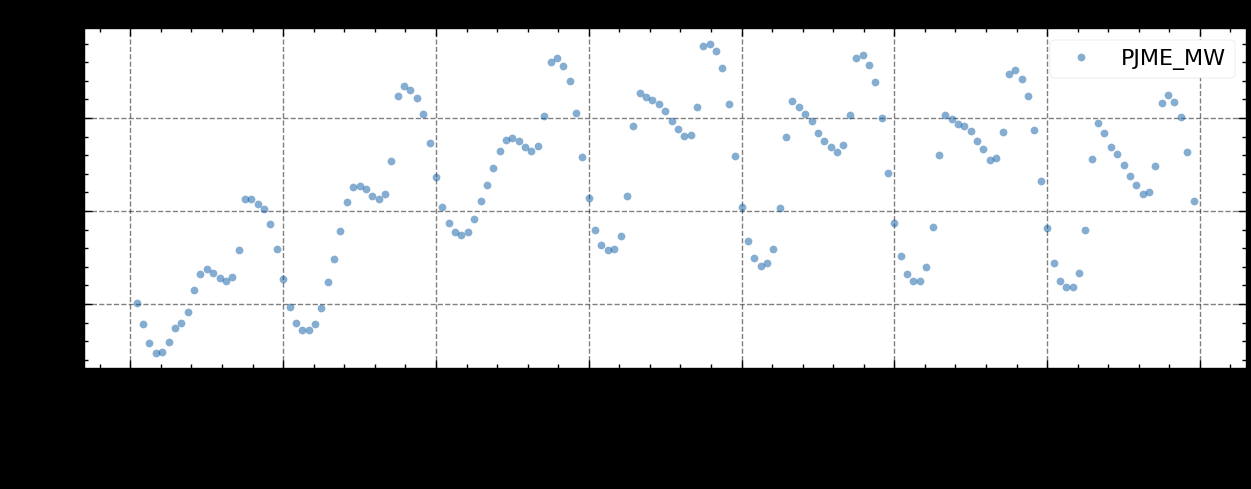

In [11]:
if CURRENT_DATASET == 'tutorial':
    week_df = df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]
    ax = week_df.plot(figsize=(15, 5), title='Week Of Data', style='o', alpha=0.5)

In [12]:
## Feature Creating >>
if CURRENT_DATASET == 'tutorial':
    def create_features(df):
        """
        Create time series features based on time series index.
        """
        df = df.copy()
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['dayofyear'] = df.index.dayofyear
        df['dayofmonth'] = df.index.day
        df['weekofyear'] = df.index.isocalendar().week
        return df

    features_lst = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
    target_lbl = 'PJME_MW'
    
    train = create_features(train)
    test = create_features(test)
    
    X_train, y_train = train[features_lst], train[target_lbl]
    X_test, y_test = test[features_lst], test[target_lbl]

## Introduction

<p align="right">
    <a href=https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467>
        <i>source</i>
    </a>
</p>

+ Common time series patterns include:
    + **Trend**: A long-term increase or decrease in the data.
    + **Seasonality**: A pattern that repeats itself at regular intervals.
    + **Cyclic**: A pattern that repeats itself at irregular intervals.
    + **Noise**: Random variation in the data.

![TS Patterns](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

+ Time series decomposition: A time series can be analyze in detail by breaking down it into its primary components. 

## 1.1. <a id='toc1_1_'></a>[Extreme Gradient Boosting (XGBoost)](#toc0_)

XGBoost is a highly efficient and scalable implementation of the gradient boosting algorithm. 
It is designed to optimize both speed and performance, making it a popular choice for machine learning tasks, particularly in competitions and large-scale data processing.

XGBoost is an ensemble learning method that combines the predictions of multiple weak models (typically decision trees) to produce a stronger prediction. It is known for its ability to handle large datasets, its robustness against overfitting through regularization, and its support for parallel and distributed computing. 

Key features include:
- **Parallelization**: XGBoost can utilize multiple CPU cores to speed up the training process.
- **Regularization**: It includes L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting.
- **Handling Missing Values**: XGBoost can handle missing values efficiently.
- **Scalability**: It supports distributed computing frameworks like Hadoop and Spark.
- **Cross-Validation**: Built-in support for cross-validation to evaluate model performance.

####  Input Parameters of `XGBRegressor`
The `XGBRegressor` function in XGBoost is used for regression tasks. 
Below are the input parameters for the function, along with their explanations and possible options:

+  `base_score`
   - **Description**: The initial prediction score of all instances, global bias.
   - **Default**: 0.5
   - **Options**: Any float value.

+ `booster`
  - **Description**: Specifies which booster to use. The booster is the model that is used for boosting.
  - **Default**: 'gbtree'
  - **Options**:
    - `'gbtree'`: Tree-based models.
    - `'gblinear'`: Linear models.
    - `'dart'`: Dropouts meet Multiple Additive Regression Trees (DART).

+ `early_stopping_rounds`
  - **Description**: Activates early stopping. If the performance does not improve for a given number of rounds, the training stops.
  - **Default**: None
  - **Options**: Any integer value.

+ `objective`
  - **Description**: Specifies the learning task and the corresponding objective function.
  - **Default**: 'reg:squarederror'
  - **Options**:
    - `'reg:squarederror'`: Regression with squared error.
    - `'reg:linear'`: Linear regression (deprecated, use 'reg:squarederror').
    - `'reg:squaredlogerror'`: Regression with squared log error.

+ `max_depth`
  - **Description**: Maximum depth of a tree. Increasing this value makes the model more complex and more likely to overfit.
  - **Default**: 6
  - **Options**: Any integer value.

+ `n_estimators`
  - **Description**: Number of gradient boosted trees. Equivalent to the number of boosting rounds.
  - **Default**: 100
  - **Options**: Any integer value.

+ `n_jobs`
  - **Description**: Number of parallel threads used to run XGBoost. This can speed up the training process.
  - **Default**: 1
  - **Options**: Any integer value, typically set to the number of CPU cores available.

+ Additional Parameters (Not in the Provided Function Call but Commonly Used)
  - **`learning_rate`**: Step size shrinkage used to prevent overfitting. Default is 0.3.
  - **`subsample`**: Subsample ratio of the training instances. Default is 1.
  - **`colsample_bytree`**: Subsample ratio of columns when constructing each tree. Default is 1.
  - **`gamma`**: Minimum loss reduction required to make a further partition on a leaf node. Default is 0.
  - **`reg_alpha`**: L1 regularization term on weights. Default is 0.
  - **`reg_lambda`**: L2 regularization term on weights. Default is 1.

In [14]:
%%time

if CURRENT_DATASET == 'tutorial':
    ## Creating the model >>
    reg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',
                           early_stopping_rounds=50,
                           objective='reg:squarederror',  # 'reg:linear', 'reg:squaredlogerror',
                           max_depth=3,
                           n_estimators=1000,
                           n_jobs=n_jobs)
    
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)  # every 100 rounds
    
    reg

[0]	validation_0-rmse:23309.99892	validation_1-rmse:22370.83503


[93]	validation_0-rmse:2761.53121	validation_1-rmse:3773.13172
CPU times: user 40 s, sys: 32.3 ms, total: 40 s
Wall time: 874 ms


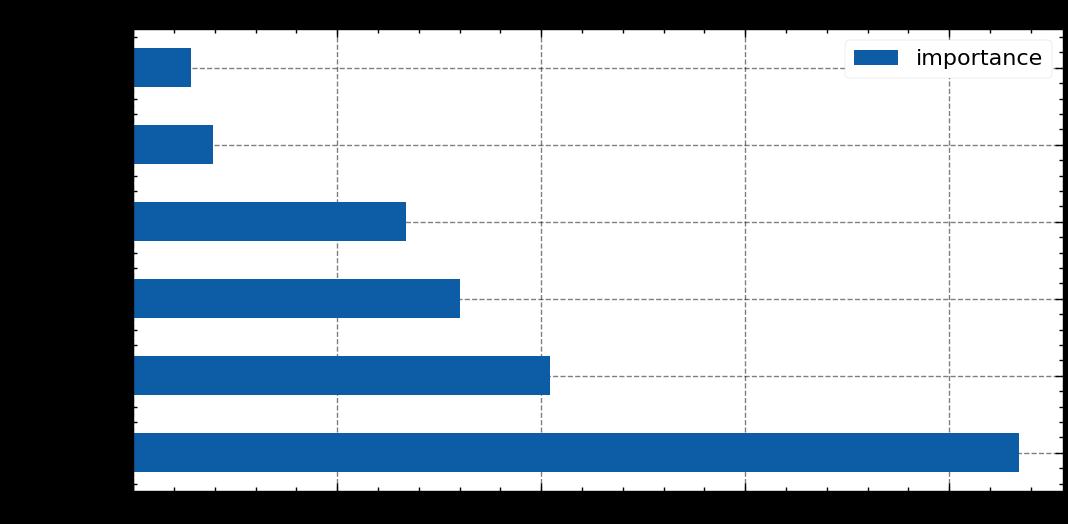

In [15]:
if CURRENT_DATASET == 'tutorial':
    ## Feature Importance >>
    feat_importances = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
    feat_importances = feat_importances.sort_values('importance', ascending=False)
    feat_importances.plot(kind='barh', figsize=(12, 6), title='Feature Importances')


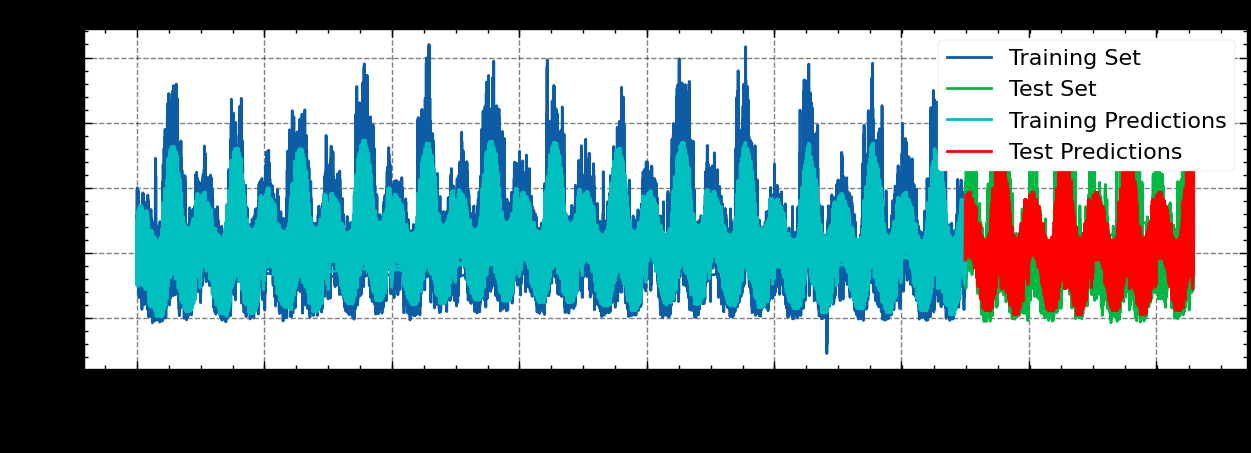

In [17]:
if CURRENT_DATASET == 'tutorial':
    ## Predictions >>
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)

    ## Plotting the predictions >>
    fig, ax = plt.subplots(figsize=(15, 5))
    train[target_lbl].plot(ax=ax, label='Training Set')
    test[target_lbl].plot(ax=ax, label='Test Set')
    ax.plot(train.index, y_pred_train, label='Training Predictions', color='c')
    ax.plot(test.index, y_pred_test, label='Test Predictions', color='r')
    ax.legend(['Training Set', 'Test Set', 'Training Predictions', 'Test Predictions'])
    ax.set_title('XGBoost Model Predictions')

In [39]:
week_df


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2016-01-07 01:00:00,31009.0,1,3,1,1,2016,7,7,1
2016-01-07 02:00:00,30314.0,2,3,1,1,2016,7,7,1
2016-01-07 03:00:00,30008.0,3,3,1,1,2016,7,7,1
2016-01-07 04:00:00,30058.0,4,3,1,1,2016,7,7,1
2016-01-07 05:00:00,30682.0,5,3,1,1,2016,7,7,1
...,...,...,...,...,...,...,...,...,...
2016-01-01 20:00:00,32530.0,20,4,1,1,2016,1,1,53
2016-01-01 21:00:00,32131.0,21,4,1,1,2016,1,1,53
2016-01-01 22:00:00,31318.0,22,4,1,1,2016,1,1,53


In [53]:
week_df['predictions']

Datetime
2016-01-07 01:00:00    31584.177734
2016-01-07 02:00:00    31065.830078
2016-01-07 03:00:00    30568.716797
2016-01-07 04:00:00    30568.716797
2016-01-07 05:00:00    30568.716797
                           ...     
2016-01-01 20:00:00    36940.066406
2016-01-01 21:00:00    37345.566406
2016-01-01 22:00:00    36569.808594
2016-01-01 23:00:00    34493.644531
2016-01-02 00:00:00    31163.935547
Name: predictions, Length: 167, dtype: float32

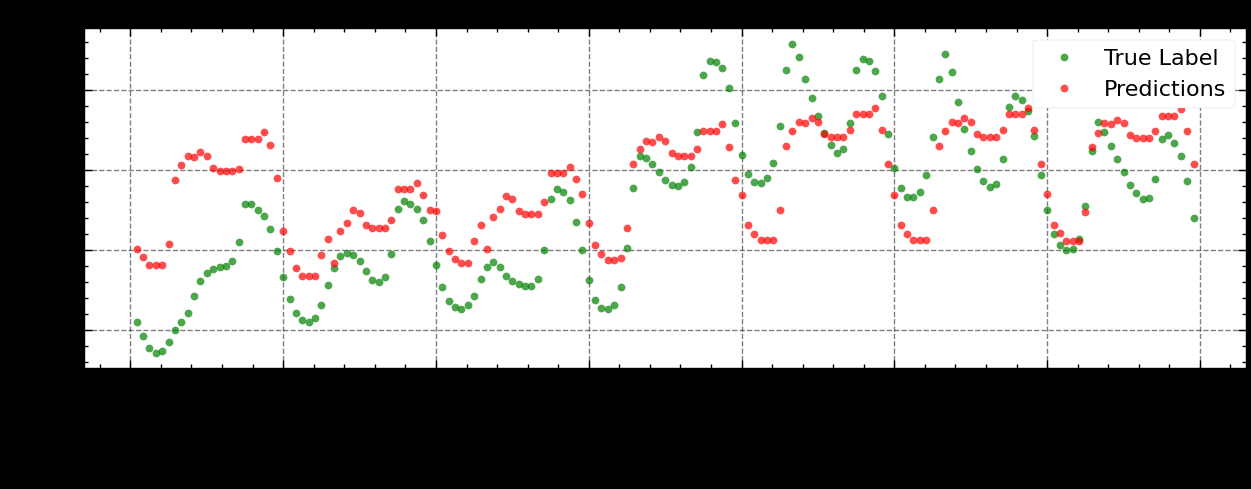

In [54]:
if CURRENT_DATASET == 'tutorial':
    fig, ax = plt.subplots(figsize=(15, 5))
    week_df = test.copy().loc[(test.index > '01-01-2016') & (test.index < '01-08-2016')]
    week_df['predictions'] = reg.predict(week_df[features_lst])
    #
    week_df[target_lbl].plot(ax=ax, color='g', alpha=0.7, style='o', label='True Label')
    week_df['predictions'].plot(ax=ax, color='r', alpha=0.7, style='o', label='Predictions')
    ax.legend()
    ax.set_title('XGBoost Model Predictions on One Week of Test Data')
    

In [ ]:
def xgboost_forecast(positions, cogs, t):
    ## Prepare the data >>
    X = np.concatenate([positions, cogs], axis=1)#.T
    # X = np.array([positions, cogs]).T
    y = np.array(positions[1:])  # Next position as target
    
    ## Train the model >>
    if DEBUG: print("Training the model...")  # Debugging
    if TIME_IT: start = time.time()  # Timing
    model = xgb.XGBRegressor()
    model.fit(X, y)
    if TIME_IT: print(f"Training time: {time.time() - start} seconds")  # Timing
    
    return model  # Debugging
    
    # ## Predict the next position >>
    # if DEBUG: print("Predicting...")  # Debugging
    # if TIME_IT: start = time.time()  # Timing
    # next_position = model.predict(np.array([positions[-1], cogs[-1]]).reshape(1, -1))
    # if TIME_IT: print(f"Predicting time: {time.time() - start} seconds")  # Timing
    # return next_position[0]

+ Example:

In [ ]:
%%time
# positions = list(zip(latitude, longitude))
positions = np.column_stack((latitude, longitude))
t = 10
# forecasted_position = xgboost_forecast(positions, cog.reshape((-1,1)), t)

model = xgboost_forecast(positions, cog.reshape((-1,1)), t)

In [ ]:
b = np.random.randint(0, 10, (2, 4))
b

In [ ]:
b[:-1]

In [ ]:
positions.shape

In [ ]:
next_position = model.predict(np.append(positions[-1], cog[-1]).reshape(-1, 1))#.reshape(1, -1))
print(next_position)

## 1.2. <a id='toc1_2_'></a>[Support Vector Regression (SVR)](#toc0_)

In [ ]:
def svr_forecast(positions, cogs, t):
    ## Prepare the data >>
    X = np.array([positions, cogs]).T
    y = np.array(positions[1:])  # Next position as target
    
    ## Train the model >>
    if DEBUG: print("Training the model...")  # Debugging
    if TIME_IT: start = time.time()  # Timing
    model = SVR()
    model.fit(X[:-1], y)
    if TIME_IT: print(f"Training time: {time.time() - start} seconds")
    
    ## Predict the next position >>
    if DEBUG: print("Predicting...")  # Debugging
    if TIME_IT: start = time.time()  # Timing
    next_position = model.predict(np.array([positions[-1], cogs[-1]]).reshape(1, -1))
    if TIME_IT: print(f"Predicting time: {time.time() - start} seconds")
    return next_position[0]



+ Example:

In [ ]:
%%time
# positions = list(zip(latitude, longitude))
positions = np.column_stack((latitude, longitude))
t = 10
forecasted_position = svr_forecast(positions, cog.reshape((-1,1)), t)

## 1.3. <a id='toc1_3_'></a>[Random Forest (RF)](#toc0_)

In [ ]:
https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [ ]:
https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost